In [1]:
cd ../..

/Users/tom/Documents/REPO/guitar-set


In [62]:
import guitar_set.pitch_tracker as ptk
import guitar_set.interpreter as itp
import librosa
import jams
import mir_eval.display
import mir_eval.sonify
import librosa.display
import numpy as np
import os
import numba
import scipy.signal as signal
import matplotlib.pyplot as plt
from IPython.display import Audio

In [63]:
def compute_novelty_spec_flux(y, fs, hop_size=512):
    """ Compute novelty function using spectural flux.
    Parameters
    ----------
    y : ndarray
    (T,) mono time domian signal
    fs : int
    sample rate of y
    win_size : int
    hop_size : int

    Returns
    -------
    novelty : ndarray
    times : ndarray
    fs_novelty : float
    """
    S = librosa.feature.melspectrogram(y=y, sr=fs, n_mels=256,
                                       hop_length=hop_size)
    S_dB = librosa.power_to_db(S, ref=np.max)
    dS_dt = np.diff(S, axis=1)
    # HW Rectify dS_dt
    for x in np.nditer(dS_dt, op_flags=['readwrite']):
        x[...] = max(x, 0)
    #

    weight_vec = np.append(np.zeros(128), np.ones(128))
    weight_vec += 1

    weighted_sf = np.dot(np.diag(weight_vec), dS_dt)

    # output gathering
    novelty = np.mean(weighted_sf, axis=0)
    fs_novelty = float(fs) / hop_size
    times = np.array([float(i) / fs_novelty for i in range(len(novelty))])

    return novelty, times, fs_novelty


def medfilt(x, k):
    """Apply a length-k median filter to a 1D array x.
    Boundaries are extended by repeating endpoints.
    """
    assert k % 2 == 1, "Median filter length must be odd."
    assert x.ndim == 1, "Input must be one-dimensional."
    k2 = (k - 1) // 2
    y = np.zeros((len(x), k), dtype=x.dtype)
    y[:, k2] = x
    for i in range(k2):
        j = k2 - i
        y[j:, i] = x[:-j]
        y[:j, i] = x[0]
        y[:-j, -(i + 1)] = x[j:]
        y[-j:, -(i + 1)] = x[-1]
    return np.median(y, axis=1)


def onsets_from_novelty(novelty, times, fs, w_c=3, medfilt_len=11,
                        offset=0.001):
    # smoothing using butterworth and normalize
    nyq = fs / 2.0
    B, A = signal.butter(1, w_c / nyq, 'low')
    novelty_smoothed = signal.filtfilt(B, A, novelty)
    novelty_smoothed = novelty_smoothed / np.max(np.abs(novelty_smoothed))

    # adaptive thresholding
    thresh = medfilt(novelty_smoothed, medfilt_len) + offset

    # onset detection
    peak_idx = librosa.util.peak_pick(novelty_smoothed, 3, 3, 3, 5, 5e-5, 10)

    pruned_peak_idx = []
    for p_idx in peak_idx:
        if novelty_smoothed[p_idx] > thresh[p_idx]:  # it made it
            pruned_peak_idx.append(p_idx)
    return pruned_peak_idx


def load_dirpath(mono_dir_path):
    """:returns
        ys, sr
    """
    ys = []
    for string_number in range(6):
        mono_path = os.path.join(mono_dir_path, '{}.wav'.format(string_number))

        y, sr = librosa.load(mono_path)
        print('length of y: {}, sr: {}'.format(len(y), sr))
        ys.append(y)
    return np.asarray(ys), sr


def qxi_onset(y, sr):
    novelty, times, fs_novelty = compute_novelty_spec_flux(y, sr, hop_size=512)
    pruned_peak_idx = onsets_from_novelty(novelty, times, fs_novelty)
    return times[pruned_peak_idx]

In [64]:
onset_t_mat = []
ys_jams = jams.JAMS()
ys_jams.file_metadata.duration = ys.shape[1] / float(sr)

for s in range(6):
#     s = 3
    y = ys[s]
    onset_times = qxi_onset(y, sr)
# onset_times = librosa.onset.onset_detect(y, sr, backtrack=True, units='time')
#     plt.figure()
#     plt.vlines(onset_times, 0, 1)
#     plt.show()
    ann = jams.Annotation(namespace='onset')
    ann.duration = ys_jams.file_metadata.duration
    ann.annotation_metadata.data_source = s
    for t in onset_times:
        ann.append(time=t, duration=0.0)

# click_track = jams.sonify.clicks(annotation=ann, sr=sr, length=ys.shape[1])
# Audio(data=click_track+y, rate=sr)
    ys_jams.annotations.append(ann)

In [78]:
def state_detect_to_ann(sd, frame_fs, string_idx):
    current_state = 'u' # 'u' for unvoiced initialize
    
    start_frame = None
    end_frame = None
    ann = jams.Annotation(namespace='note_midi')
    def produce_note():
        start_time = librosa.frames_to_time(start_frame)[0]
        duration = librosa.frames_to_time(end_frame)[0] - start_time
        fret_idx = (start_frame+end_frame) / 2
        fret_state = sd[fret_idx]
        fret = ptk.STATE_INDEX[fret_state]
        pitch = fret + ptk.STR_MIDI_DICT[string_idx]
        print(start_time, duration, fret, pitch)
        ann.append(time=start_time,
                  duration=duration,
                  value=pitch)
    
    
    for i in range(len(sd)):
        if current_state == 'u':
            if sd[i] == -104: # new state is unvoiced
                pass
            else: # state is now voiced
                start_frame = i
                start_ps = sd[i]
                current_state = 'v'
                
        elif current_state == 'v':
            if sd[i] == -104: # new state is unvoiced
                end_frame = i
                produce_note()
                current_state = 'u'
            elif np.abs(sd[i]-start_ps) >= 3 : # state is now voiced but new note
                end_frame = i
                produce_note()
                start_frame = i
                start_ps = sd[i]
            else: # new state is voiced and the same note
                pass
        else:
            print('invalid state!')
            
    
    return ann

def states_to_notes(state_detects, frame_fs, orig_duration):
    ys_jams = jams.JAMS()
    ys_jams.file_metadata.duration = orig_duration
    string_idx = 0
    for sd in state_detects:
        ann = state_detect_to_ann(sd, frame_fs, string_idx)
        ann.duration = orig_duration
        ys_jams.annotations.append(ann)
        string_idx += 1
    return ys_jams

In [72]:
mono_dir_path = '/Users/tom/Music/DataSet/test-set_processed/eh_BN1-129-Eb_c_hex_cln/'
ys, sr = load_dirpath(mono_dir_path)

length of y: 485100, sr: 22050
length of y: 485100, sr: 22050
length of y: 485100, sr: 22050
length of y: 485100, sr: 22050
length of y: 485100, sr: 22050
length of y: 485100, sr: 22050


In [73]:
state_detects = ptk.run(mono_dir_path)
frame_fs = sr / 516.0
length = ys.shape[1] / float(sr)

485100
max_lag:300 min_lag:66
acf.shape:(300, 947)
485100
max_lag:225 min_lag:50
acf.shape:(225, 948)
485100
max_lag:168 min_lag:37
acf.shape:(168, 948)
485100
max_lag:126 min_lag:28
acf.shape:(126, 948)
485100
max_lag:100 min_lag:22
acf.shape:(100, 948)
485100
max_lag:75 min_lag:16
acf.shape:(75, 948)
(None, 0.005)


In [74]:
state_detects[0]

array([-104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104,   28,   29,   30,   31, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -104, -104, -104, -104,
       -104, -104, -104, -104, -104, -104, -104, -1

In [79]:
ys_jams = states_to_notes(state_detects, frame_fs, length)

(2.8560544217687074, 0.069659863945578326, 5.25, 45.25)
(2.9257142857142857, 0.023219954648526109, 5.75, 45.75)
(7.1749659863945574, 0.20897959183673542, 1.25, 41.25)
(7.3839455782312928, 0.069659863945577882, 2.25, 42.25)
(7.4536054421768707, 0.046439909297052218, 3.25, 43.25)
(7.5000453514739229, 0.16253968253968232, 3.5, 43.5)
(7.6625850340136052, 0.092879818594104435, 3.0, 43.0)
(7.7554648526077097, 0.069659863945577882, 3.75, 43.75)
(7.8251247165532876, 2.5309750566893436, 4.5, 44.5)
(10.425759637188209, 0.76625850340136026, 3.25, 43.25)
(14.489251700680272, 0.11609977324263099, 5.25, 45.25)
(14.605351473922903, 0.2321995464852602, 0.5, 40.5)
(14.837551020408164, 0.37151927437641774, 6.25, 46.25)
(15.209070294784581, 0.74303854875283371, 6.5, 46.5)
(15.952108843537415, 0.069659863945579659, 2.25, 42.25)
(16.021768707482995, 0.13931972789115576, 3.0, 43.0)
(16.16108843537415, 0.092879818594102659, 3.75, 43.75)
(16.253968253968253, 2.0201360544217692, 4.5, 44.5)
(18.274104308390022,

In [80]:
ys_jams

,time,duration,value,confidence
0,2.856,0.070,45.25,None
1,2.926,0.023,45.75,None
2,7.175,0.209,41.25,None
3,7.384,0.070,42.25,None
4,7.454,0.046,43.25,None
5,7.500,0.163,43.5,None
6,7.663,0.093,43.0,None
7,7.755,0.070,43.75,None
8,7.825,2.531,44.5,None
9,10.426,0.766,43.25,None


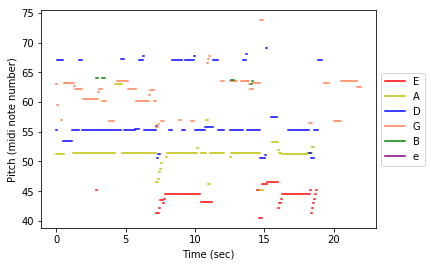

In [81]:
itp.visualize_jams(ys_jams)

In [82]:
data = itp.sonify_jams(ys_jams)
Audio(data=data,rate=44100)